<a href="https://colab.research.google.com/github/LouisVanLangendonck/UPC-AML-ArchitectureClassif/blob/main/MLP_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Multilayer Perceptron on extracted features

Specify here the path to the MAIN DIRECTORY of the project

In [ ]:
project_dir = '/content/drive/MyDrive/FIB-2022-2023/aml'

## Imports and preparation

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import keras
import random
import pandas as pd
import random
! pip install tensorflow-addons
! pip install focal-loss
import tensorflow_addons as tfa
from keras import optimizers, models, layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

print("TF version:", tf.__version__)
print("keras version:", keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
TF version: 2.9.2
keras version: 2.9.0
GPU is available
Mounted at /content/drive


In [ ]:
#@title To be able to load in the big feature vectors in numpy

# Never load this twice in one session! Otherwise it will give a pickle error

np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

## Loading In the Features and optionally concatenating them

In [ ]:
#@title Load in features without concatenation
feature_vector_family = 'efficientnetb7'
(train_features, train_labels), (test_features, test_labels) = np.load(os.path.join(path_to_aml_file,'models/extracted_features/{}.npy'.format(feature_vector_family)))
model_naming = 'feat+mlp_{}'.format(feature_vector_family)

In [ ]:
#@title Load in features with concatenation

concat_path_base = os.path.join(path_to_aml_file,'models/extracted_features/')
#concat_path_list = ['inception_resnet_v2.npy', 'vgg19.npy', 'xception.npy']
concat_path_list = ['inception_resnet_v2.npy', 'vgg19.npy', 'xception.npy', 'SIFT.npy', 'efficientnetb7.npy']
train_features = []
test_features = []
model_naming = 'feat+mlp_'

for idx, feature_file in enumerate(concat_path_list):
  
    feature_path = os.path.join(concat_path_base, feature_file)
    (train_features_to_concat, train_labels), (test_features_to_concat, test_labels) = np.load(feature_path)
    if idx == 0:
      train_features = train_features_to_concat
      test_features = test_features_to_concat
    else:
      train_features=np.append(train_features, train_features_to_concat, 1)
      test_features=np.append(test_features, test_features_to_concat, 1)

    if idx+1 != len(concat_path_list):
        model_naming = model_naming+(feature_file.split('.')[0])+'+'
    else:
        model_naming = model_naming+(feature_file.split('.')[0])

## Train-validation split and class weights calculation

In [ ]:
#@title stratified train-val split (with random state fixed) for eventual model validation

from sklearn.model_selection import train_test_split
        
inp_train_features, inp_val_features, train_labels, val_labels = train_test_split(train_features, train_labels,
                                                    stratify=train_labels,
                                                    shuffle=True,
                                                    test_size=0.20, 
                                                    random_state=1)

nr_train_images = train_labels.shape[0]
nr_test_images = test_labels.shape[0]
nr_val_images = val_labels.shape[0]

In [ ]:
#@title Computing class weight to use in training to combat class imbalance

integer_coding_labels = np.array([np.where(r==1)[0][0] for r in train_labels])

class_weights = compute_class_weight(class_weight ='balanced',classes =np.unique(integer_coding_labels),
                                                 y = integer_coding_labels)

class_weights_dict = {k: v for k, v in enumerate(class_weights)}
class_weights_dict

{0: 1.0073770491803278,
 1: 1.7285513361462728,
 2: 1.440797186400938,
 3: 0.6154231347020531,
 4: 1.6474530831099197,
 5: 0.5816374822527213,
 6: 4.535055350553505,
 7: 0.6397709526288391}

## Writing a Model Builder Function with costum loss function. 

In [ ]:
def focal_loss(gamma=2., alpha=class_weights):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """
        https://arxiv.org/abs/1708.02002
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
#@title Model Builder function that returns keras model type. To be used often later.

f1 = tfa.metrics.F1Score(8,'weighted')

def model_builder(first_layer, second_layer,opt, learning_rate,third_layer=0, dropout = True, load_weights_path=None, loss_function='crossentropy'):
    model = models.Sequential()
    if dropout:
        model.add(layers.Dropout(0.5))
    model.add(layers.Dense(first_layer, activation='relu', input_dim=inp_train_features.shape[1]))
    if second_layer != 0:
        model.add(layers.Dense(second_layer, activation='relu'))
    if second_layer != 0 and third_layer != 0:
        model.add(layers.Dense(third_layer, activation='relu'))
    model.add(layers.Dense(8,activation = 'softmax'))
    if load_weights_path != None:
        model.load_weights(load_weights_path)
    if opt == 'adam' and loss_function == 'crossentropy':
        model.compile(optimizer=optimizers.Adam(learning_rate = learning_rate),
              loss='categorical_crossentropy',
              metrics=[f1, 'acc'])
    elif opt == 'adam' and loss_function == 'focal':
        model.compile(optimizer=optimizers.Adam(learning_rate = learning_rate),
              loss=focal_loss(alpha=1),
              metrics=[f1, 'acc'])
    elif opt == 'SGD' and loss_function == 'crossentropy':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[f1, 'acc'])
    elif opt == 'SGD' and loss_function == 'focal':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss=focal_loss(alpha=1),
              metrics=[f1, 'acc'])
    return model

## Model training including costum Parameter Grid

In [ ]:
#@title Manual Grid for configuration parameters (random seed fixed)

primary_layer_choice = [512, 256, 128]
secondary_layer_choice = [256, 128, 0]
optimizers_choices = ['SGD', 'adam']
third_layer_choice = [128, 0, 0]
sgd_lr = [0.01, 0.05]
adam_lr = [0.001, 0.005]

random.seed(3)
combs = [[random.choice(primary_layer_choice), random.choice(secondary_layer_choice), random.choice(optimizers_choices)] for _ in range (5)]
for choice in combs:
  if choice[2] == 'adam':
          choice.append(random.choice(adam_lr))
  elif choice[2] == 'SGD':
          choice.append(random.choice(sgd_lr))
  if choice[1] != 0:
          choice.append(random.choice(third_layer_choice))
combs

[[512, 0, 'SGD', 0.01],
 [256, 0, 'adam', 0.005],
 [128, 0, 'SGD', 0.05],
 [128, 256, 'adam', 0.005, 0],
 [256, 0, 'SGD', 0.01]]

In [ ]:
configurations = combs
use_focal_loss = True
class_weights_included = False

X_train, X_val = inp_train_features, inp_val_features
y_train, y_val = train_labels, val_labels

for conf in configurations:
      if len(conf) > 4:
        if use_focal_loss:
          model_ = model_builder(conf[0], conf[1], conf[2], conf[3], third_layer=conf[4], loss_function='focal')      
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_{}_lr:{}_{}/'.format(model_naming, conf[0],conf[1],conf[4],conf[2],conf[3],'focal'))
        else:
          model_ = model_builder(conf[0], conf[1], conf[2], conf[3], third_layer=conf[4])      
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_{}_lr:{}/'.format(model_naming, conf[0],conf[1],conf[4],conf[2],conf[3]))
      
      else:
        if use_focal_loss:
          model_ = model_builder(conf[0], conf[1], conf[2], conf[3], loss_function='focal')      
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_lr:{}_{}/'.format(model_naming, conf[0],conf[1],conf[2],conf[3],'focal'))
        else:
          model_ = model_builder(conf[0], conf[1], conf[2], conf[3])      
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_lr:{}/'.format(model_naming, conf[0],conf[1],conf[2],conf[3]))

      if not class_weights_included and not use_focal_loss:
        model_path = model_path[:-1] + '_no_sample_weights/'

      if not os.path.exists(model_path):
          os.makedirs(model_path)

      my_callbacks = [
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'model.epo:{epoch:02d}-val_loss:{val_loss:.3f}--.h5', save_weights_only=True,monitor='val_acc'),
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'best_val_loss.h5', save_weights_only=True,save_best_only=True, monitor='val_loss'),
  tf.keras.callbacks.CSVLogger(model_path + 'history.csv', separator=",", append=False)
      ]

      if not class_weights_included:
        model_.fit(X_train,
                y_train, 
                epochs=90, 
                batch_size=10, 
                validation_data = (X_val, y_val),
                callbacks=my_callbacks)
      else:
        model_.fit(X_train,
                y_train, 
                epochs=90, 
                batch_size=10, 
                validation_data = (X_val, y_val),
                callbacks=my_callbacks,
                class_weight=class_weights_dict)
      
      del model_
      keras.backend.clear_session()
      tf.compat.v1.reset_default_graph()

Epoch 1/90
984/984 [==============================] - 10s 6ms/step - loss: 1.4366 - f1_score: 0.1743 - acc: 0.2213 - val_loss: 1.4033 - val_f1_score: 0.1652 - val_acc: 0.2582
Epoch 2/90
984/984 [==============================] - 5s 6ms/step - loss: 1.4076 - f1_score: 0.1854 - acc: 0.2428 - val_loss: 1.4021 - val_f1_score: 0.1902 - val_acc: 0.2631
Epoch 3/90
984/984 [==============================] - 7s 7ms/step - loss: 1.3945 - f1_score: 0.1902 - acc: 0.2473 - val_loss: 1.3807 - val_f1_score: 0.1170 - val_acc: 0.2338
Epoch 4/90
984/984 [==============================] - 4s 4ms/step - loss: 1.3881 - f1_score: 0.1958 - acc: 0.2554 - val_loss: 1.3645 - val_f1_score: 0.1653 - val_acc: 0.2684
Epoch 5/90
984/984 [==============================] - 5s 5ms/step - loss: 1.3842 - f1_score: 0.1964 - acc: 0.2549 - val_loss: 1.3710 - val_f1_score: 0.1802 - val_acc: 0.2505
Epoch 6/90
984/984 [==============================] - 6s 6ms/step - loss: 1.3764 - f1_score: 0.2030 - acc: 0.2623 - val_loss: 1.3

## Performance on the Validation Set

77/77 [==============================] - 0s 2ms/step

Classification Report

               precision    recall  f1-score   support

      baroque       0.46      0.55      0.50       305
 contemporary       0.75      0.73      0.74       178
       gothic       0.42      0.38      0.40       214
    modernism       0.64      0.54      0.58       499
neoclassicism       0.52      0.21      0.30       186
  noucentisme       0.56      0.70      0.62       529
  renaissance       0.17      0.16      0.17        68
   romanesque       0.76      0.82      0.78       480

     accuracy                           0.59      2459
    macro avg       0.54      0.51      0.51      2459
 weighted avg       0.59      0.59      0.58      2459

More precise weighted avg F1-score (not to be confused with the macro-F1 score from above): 0.5841514187023347


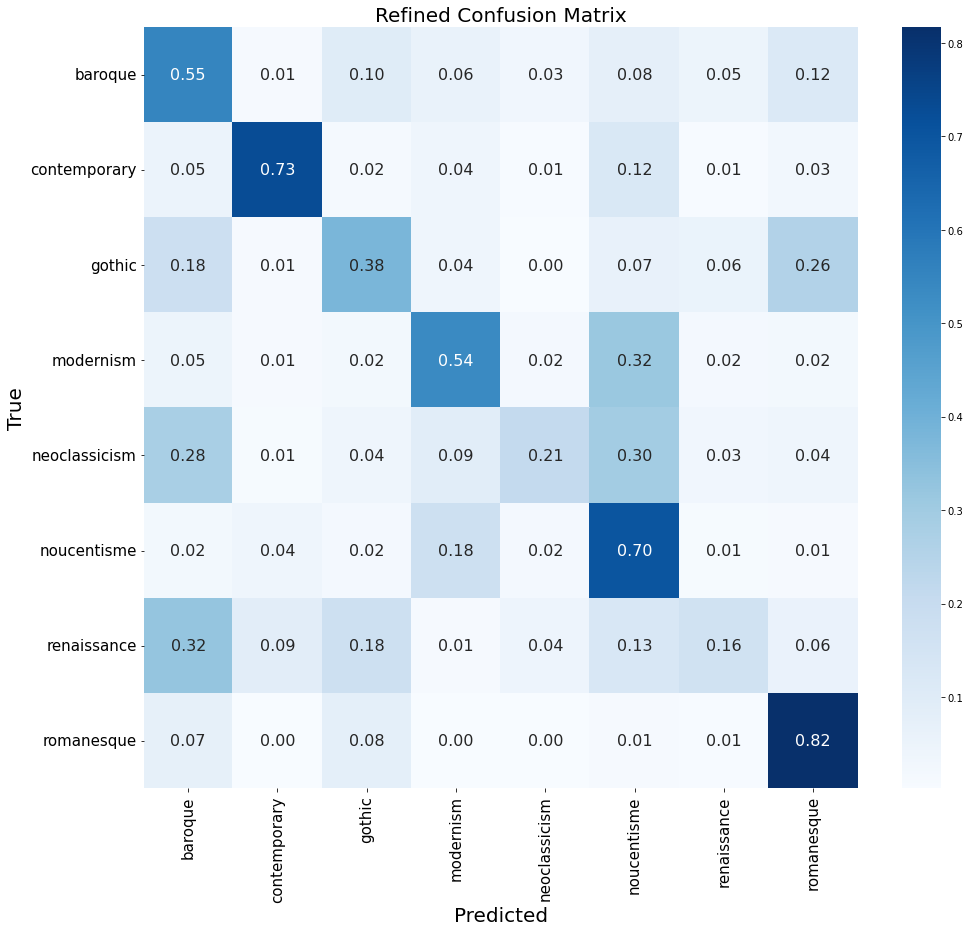

In [ ]:
best_model_params = [512, 0, 'SGD', 0.01]
use_focal_loss = False
class_weights_included = True

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,f1_score

if len(best_model_params) > 4:
      if use_focal_loss:     
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_{}_lr:{}_{}/'.format(model_naming, best_model_params[0],best_model_params[1],best_model_params[4],best_model_params[2],best_model_params[3],'focal'))
          if not class_weights_included and not use_focal_loss:
              model_path = model_path[:-1] + '_no_sample_weights/'
          model1 = model_builder(best_model_params[0], best_model_params[1], best_model_params[2], best_model_params[3], third_layer=best_model_params[4], loss_function='focal', dropout=False, load_weights_path=os.path.join(model_path, 'best_val_loss.h5')) 
      else:
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_{}_lr:{}/'.format(model_naming, best_model_params[0],best_model_params[1],best_model_params[4],best_model_params[2],best_model_params[3]))
          if not class_weights_included and not use_focal_loss:
              model_path = model_path[:-1] + '_no_sample_weights/'
          model1 = model_builder(best_model_params[0], best_model_params[1], best_model_params[2], best_model_params[3], third_layer=best_model_params[4], dropout=False, load_weights_path=os.path.join(model_path, 'best_val_loss.h5'))
      
else:
      if use_focal_loss:     
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_lr:{}_{}/'.format(model_naming, best_model_params[0],best_model_params[1],best_model_params[2],best_model_params[3],'focal'))
          if not class_weights_included and not use_focal_loss:
              model_path = model_path[:-1] + '_no_sample_weights/'
          model1 = model_builder(best_model_params[0], best_model_params[1], best_model_params[2], best_model_params[3], loss_function='focal', dropout=False, load_weights_path=os.path.join(model_path, 'best_val_loss.h5')) 
      else:
          model_path = os.path.join(path_to_aml_file,'models/mlp_models_selection/{}/model_{}_{}_{}_lr:{}/'.format(model_naming, best_model_params[0],best_model_params[1],best_model_params[2],best_model_params[3]))
          if not class_weights_included and not use_focal_loss:
              model_path = model_path[:-1] + '_no_sample_weights/'
          model1 = model_builder(best_model_params[0], best_model_params[1], best_model_params[2], best_model_params[3], dropout=False, load_weights_path=os.path.join(model_path, 'best_val_loss.h5'))

def pretty_confusion(y_true, y_pred, labels, normalize=True):
  if normalize:
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true')
  else:
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
  fig = plt.figure(figsize=(16, 14))
  ax= plt.subplot()
  if normalize:
    sns.heatmap(cm, annot=True, ax = ax, fmt=".2f", cmap='Blues', annot_kws={
                'fontsize': 16})
  else:
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap='Blues', annot_kws={
                'fontsize': 16})
  # labels, title and ticks
  ax.set_xlabel('Predicted', fontsize=20)
  ax.xaxis.set_label_position('bottom')
  plt.xticks(rotation=90)
  ax.xaxis.set_ticklabels(labels, fontsize = 15)
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True', fontsize=20)
  ax.yaxis.set_ticklabels(labels, fontsize = 15)
  plt.yticks(rotation=0)

  plt.title('Refined Confusion Matrix', fontsize=20)

  plt.show()

def val_report(loaded_model, validation_features_set):
    y_predic = loaded_model.predict(validation_features_set)
    label_list = ['baroque', 'contemporary', 'gothic', 'modernism', 'neoclassicism', 'noucentisme', 'renaissance', 'romanesque']

    y_true = []
    for true in val_labels.argmax(axis=1):
      y_true.append(label_list[true])

    y_pred = []
    for pred in y_predic.argmax(axis=1):
      y_pred.append(label_list[pred])

    print('\nClassification Report\n')
    print(classification_report(y_true, y_pred))
    print('More precise weighted avg F1-score (not to be confused with the macro-F1 score from above): {}'.format(f1_score(y_true, y_pred, average='weighted')))
    pretty_confusion(y_true, y_pred, label_list, True)


val_report(model1, inp_val_features)